# Big Data Tools Final Project

---

### Authors:
- **Rohan Taneja**
- **Julian Subagiyo**

---

### Project Overview:
This notebook serves as the final project submission for the Big Data Tools course. It includes the analysis, insights, and implementation details related to the project topic of review score prediction.

---




## Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler, Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression ,GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator ,BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F



ImportError: Matplotlib requires numpy>=1.23; you have 1.22.0

Initializing Spark Session

In [ ]:
spark = SparkSession.builder \
    .master("local") \
    .appName("BigDataProject") \
    .getOrCreate()

Imports

In [ ]:
def load_csv(file_name):
    """Helper function to load a CSV file into a Spark DataFrame."""
    return spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(file_name)

# Base directory for data files
data_dir = r"C:\Users\omgit\Desktop\Big Data Proj\Data-20250203"

# Load datasets
order_items = load_csv(f"{data_dir}\order_items.csv")
products = load_csv(f"{data_dir}\products.csv")
order_payments = load_csv(f"{data_dir}\order_payments.csv")
order_reviews = load_csv(f"{data_dir}\order_reviews.csv")
orders = load_csv(f"{data_dir}\orders.csv")

Function that checks for NULLS or NA values in a given dataset:

In [ ]:
# Function to count missing values
def count_missing_values(df):
    return df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Function to count 'NA' values
def count_na_values(df):
    return df.select([count(when(col(c) == 'NA', c)).alias(c) for c in df.columns])

# Display missing and 'NA' values count for each dataset
for df, name in zip([order_items, products, order_payments, order_reviews], 
                    ["order_items", "products", "order_payments", "order_reviews",'orders']):
    print(f"Missing values in {name}:")
    display(count_missing_values(df))
    print(f"'NA' values in {name}:")
    display(count_na_values(df))

Missing values in order_items:


DataFrame[order_id: bigint, order_item_id: bigint, product_id: bigint, price: bigint, shipping_cost: bigint]

'NA' values in order_items:


DataFrame[order_id: bigint, order_item_id: bigint, product_id: bigint, price: bigint, shipping_cost: bigint]

Missing values in products:


DataFrame[product_id: bigint, product_name_lenght: bigint, product_description_lenght: bigint, product_photos_qty: bigint, product_weight_g: bigint, product_length_cm: bigint, product_height_cm: bigint, product_width_cm: bigint, product_category_name: bigint]

'NA' values in products:


DataFrame[product_id: bigint, product_name_lenght: bigint, product_description_lenght: bigint, product_photos_qty: bigint, product_weight_g: bigint, product_length_cm: bigint, product_height_cm: bigint, product_width_cm: bigint, product_category_name: bigint]

Missing values in order_payments:


DataFrame[order_id: bigint, payment_sequential: bigint, payment_type: bigint, payment_installments: bigint, payment_value: bigint]

'NA' values in order_payments:


DataFrame[order_id: bigint, payment_sequential: bigint, payment_type: bigint, payment_installments: bigint, payment_value: bigint]

Missing values in order_reviews:


DataFrame[review_id: bigint, order_id: bigint, review_score: bigint, review_creation_date: bigint, review_answer_timestamp: bigint]

'NA' values in order_reviews:


DataFrame[review_id: bigint, order_id: bigint, review_score: bigint, review_creation_date: bigint, review_answer_timestamp: bigint]

## Order Items and Products Table

We first partition by order_id to sort the data and use aggregate functions to create total_price_of_order and total_shipping_of_order

In [ ]:
window_spec = Window.partitionBy("order_id")
order_items = order_items.withColumn("total_items_in_order", count("order_item_id").over(window_spec))

total_costs = order_items.groupBy("order_id").agg(
    sum(col("price")).alias("total_price_of_order"),
    sum(col("shipping_cost")).alias("total_shipping_of_order")
    )

total_costs.orderBy("order_id").show(5)

+--------------------+--------------------+-----------------------+
|            order_id|total_price_of_order|total_shipping_of_order|
+--------------------+--------------------+-----------------------+
|00010242fe8c5a6d1...|               11.78|                   2.66|
|00018f77f2f0320c5...|               47.98|                   3.99|
|00042b26cf59d7ce6...|               39.98|                   3.63|
|00054e8431b9d7675...|                3.98|                   2.37|
|00061f2a7bc09da83...|                12.0|                   1.78|
+--------------------+--------------------+-----------------------+
only showing top 5 rows



Join the order_items DataFrame with the total_costs DataFrame on the "order_id" column
. Drop the columns "order_item_id", "price", and "shipping_cost" from the order_items DataFrame

In [ ]:
order_items = order_items.join(total_costs, "order_id", how='left')

order_items = order_items.drop("order_item_id", "price", "shipping_cost")

Sort by order_id for next aggregate functions

In [ ]:
order_items = order_items.orderBy("order_id")

We choose to join product table here since it will allow us to create new features easier (left join because it's products has less rows than order_items)

In [ ]:
order_items_products = order_items.join(products,"product_id","left")

Dropping NA values from the join

In [ ]:
order_items_products = order_items_products.dropna()

We identify upto 70 different product categories in this table

In [ ]:
distinct_values = order_items_products.select("product_category_name").distinct()
distinct_values.show(truncate=False)

+-------------------------+
|product_category_name    |
+-------------------------+
|art                      |
|flowers                  |
|home_construction        |
|fashion_male_clothing    |
|small_appliances         |
|bed_bath_table           |
|signaling_and_security   |
|office_furniture         |
|computers                |
|watches_gifts            |
|auto                     |
|fashion_bags_accessories |
|construction_tools_lights|
|cool_stuff               |
|cds_dvds_musicals        |
|food                     |
|computers_accessories    |
|perfumery                |
|pet_shop                 |
|stationery               |
+-------------------------+
only showing top 20 rows



Creating our first feature 'product_volume' by using dimensions and basic math

In [ ]:
order_items_products = order_items_products.withColumn(
    'product_volume',
    col('product_length_cm') * col('product_height_cm') * col('product_width_cm')
)

Aggregation of order-level data:

- average_product_desc_length: Average length of product descriptions in an order
- average_product_name_length: Average length of product names in an order
- total_items_in_order: Total number of items in an order
- total_price_of_order: Total price of all items in an order
- total_shipping_of_order: Total shipping cost for an order
- sum_of_all_products_weight: Sum of the weights of all products in an order
- categories: Unique categories of products stored in an array
- total_photos_in_order: Total number of photos associated with products in an order
- total_product_volume: Sum of product volumes in an order


In [ ]:
order_items_grouped = order_items_products.groupBy("order_id").agg(
    
    avg("product_description_lenght").alias("average_product_desc_length"),
    avg("product_name_lenght").alias("average_product_name_length"),  
    round(F.first("total_items_in_order"),2).alias("total_items_in_order"),       
    round(F.first("total_price_of_order"),2).alias("total_price_of_order"),
    round(F.first("total_shipping_of_order"),2).alias("total_shipping_of_order"),
    sum('product_weight_g').alias('sum_of_all_products_weight'),
    F.first("product_category_name").alias("category"),
    sum('product_photos_qty').alias('total_photos_in_order'),
    sum('product_volume').alias('total_product_volume')        
)

Replacing our original dataset with the new one

In [ ]:
order_items_products = order_items_grouped

Overview of certain features so we can bin them

In [ ]:
order_items_products.select("average_product_desc_length").summary().show()
order_items_products.select("average_product_name_length").summary().show()
order_items_products.select("sum_of_all_products_weight").summary().show()
order_items_products.select("total_photos_in_order").summary().show()
order_items_products.select("total_product_volume").summary().show()

+-------+---------------------------+
|summary|average_product_desc_length|
+-------+---------------------------+
|  count|                      50287|
|   mean|          781.7862992031796|
| stddev|           645.119556602168|
|    min|                        4.0|
|    25%|                      348.0|
|    50%|                      599.0|
|    75%|                      981.0|
|    max|                     3976.0|
+-------+---------------------------+

+-------+---------------------------+
|summary|average_product_name_length|
+-------+---------------------------+
|  count|                      50287|
|   mean|         48.829516912747664|
| stddev|           9.94856844283852|
|    min|                        5.0|
|    25%|                       42.0|
|    50%|                       52.0|
|    75%|                       57.0|
|    max|                       76.0|
+-------+---------------------------+

+-------+--------------------------+
|summary|sum_of_all_products_weight|
+-------+---

Binning

In [ ]:
bucketBorders = [3.0, 350.0, 600.0, 985.0, 4000.0]
order_items_products = Bucketizer(inputCol="average_product_desc_length", outputCol="Buckets_descr",splits=bucketBorders).transform(order_items_products)
bucketBorders_name = [3.0, 50.0, 100.0]
order_items_products = Bucketizer(inputCol="average_product_name_length", outputCol="Buckets_name",splits=bucketBorders_name).transform(order_items_products)
bucketBorders_weight = [0.0, 300.0, 800.0, 2000.0, 150000.0]
order_items_products = Bucketizer(inputCol="sum_of_all_products_weight", outputCol="Buckets_weight",splits=bucketBorders_weight).transform(order_items_products)
bucketBorders_volume = [0.0, 3000.0, 8000.0, 20000.0, 900000.0]
order_items_products = Bucketizer(inputCol="total_product_volume", outputCol="Buckets_volume",splits=bucketBorders_volume).transform(order_items_products)

and subsequent dropping of existing variables

In [ ]:
columns_to_drop = [
    "average_product_desc_length", 
    "average_product_name_length", 
    "sum_of_all_products_weight", 
    "total_product_volume"
]

order_items_products = order_items_products.drop(*columns_to_drop)

## Orders table

Checking for nulls

In [ ]:
count_missing_values(orders).show()
count_na_values(orders).show()

+--------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-----------+
|order_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|customer_id|
+--------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-----------+
|       0|           0|                       0|                0|                           0|                            0|                            0|          0|
+--------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-----------+

+--------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+----

We chose to exclude any orders that were not marked as "delivered," as we believed the reviews associated with them stemmed from an inconsistent process and would not provide meaningful insights into the reviews.

In [ ]:
orders = orders.where(col("order_status")== "delivered").select("*")
orders = orders.drop("order_status")

Defining a new variable, delivery time, measured in days.

In [ ]:
orders = orders.withColumn(
    "delivery_time",
    when(
        col("order_purchase_timestamp").isNotNull() & col("order_delivered_customer_date").isNotNull(),
        round(((unix_timestamp(col("order_delivered_customer_date")) - unix_timestamp(col("order_purchase_timestamp"))) / 86400).cast("double"), 2)
    ).otherwise(-1)
)

Checking for nulls after we create the new variable.

In [ ]:
count_missing_values(orders).show()
count_na_values(orders).show()

+--------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-----------+-------------+
|order_id|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|customer_id|delivery_time|
+--------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-----------+-------------+
|       0|                       0|                0|                           0|                            0|                            0|          0|            3|
+--------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-----------+-------------+

+--------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-----------+

Dropping nulls

In [ ]:
orders = orders.dropna()

Over here we do the following:

1. Convert Dates to Timestamps:
   - The `order_delivered_customer_date` and `order_estimated_delivery_date` columns are converted to timestamp format for further time-based calculations.

2. Add `delivered_on_time` Column:
   - Creates a new boolean column that checks if the order was delivered on or before the estimated delivery date.

3. Add `estimated_vs_actual_delay_days` Column:
   - Computes the difference (in days) between the actual delivery date and the estimated delivery date.
   - Positive values indicate delays, while negative values indicate early delivery.

4. Add `delivered_early` Column:
   - Creates a boolean column indicating if the order was delivered earlier than the estimated delivery date.

5. Add `approval_time` Column:
   - Calculates the time (in days) it took for the order to be approved after the purchase timestamp.
   - If any of the timestamps are missing, assigns a default value of `-1`.

6. Add `delay_status` Column:
   - Creates a boolean column indicating whether the order was delayed (actual delivery date is later than the estimated delivery date).

In [ ]:
from pyspark.sql.functions import col, dayofweek, when
# Convert date columns to timestamp format
orders = orders.withColumn("order_delivered_customer_date", to_timestamp(col("order_delivered_customer_date"))) \
               .withColumn("order_estimated_delivery_date", to_timestamp(col("order_estimated_delivery_date")))

# Add calculated columns
orders = orders.withColumn(
    "estimated_vs_actual_delay_days",
    round((unix_timestamp(col("order_delivered_customer_date")) - unix_timestamp(col("order_estimated_delivery_date"))) / 86400, 2)
) \
.withColumn(
    "approval_time",
    when(
        col("order_purchase_timestamp").isNotNull() & col("order_approved_at").isNotNull(),
        round((unix_timestamp(col("order_approved_at")) - unix_timestamp(col("order_purchase_timestamp"))) / 86400, 2)
    ).otherwise(-1)
) \
.withColumn(
    "delivery_status",
    when(col("order_delivered_customer_date") < col("order_estimated_delivery_date"), 0)  # Early delivery
    .when(col("order_delivered_customer_date") == col("order_estimated_delivery_date"), 1)  # On-time delivery
    .otherwise(2)  # Late delivery
)



# Define weekend days (Saturday = 7, Sunday = 1)
WEEKEND_DAYS = [1, 7]

# Create new variables
orders = orders.withColumn(
    "order_placed_weekend",
    when(dayofweek(col("order_purchase_timestamp")).isin(WEEKEND_DAYS), 1).otherwise(0)
).withColumn(
    "order_delivered_weekend",
    when(dayofweek(col("order_delivered_customer_date")).isin(WEEKEND_DAYS), 1).otherwise(0)
)


Dropping nulls again

In [ ]:
orders= orders.dropna()

## Order Reviews Table

Checking for nulls

In [ ]:
count_na_values(order_reviews).show()
count_missing_values(order_reviews).show()

+---------+--------+------------+--------------------+-----------------------+
|review_id|order_id|review_score|review_creation_date|review_answer_timestamp|
+---------+--------+------------+--------------------+-----------------------+
|        0|       0|           0|                   0|                     11|
+---------+--------+------------+--------------------+-----------------------+

+---------+--------+------------+--------------------+-----------------------+
|review_id|order_id|review_score|review_creation_date|review_answer_timestamp|
+---------+--------+------------+--------------------+-----------------------+
|        0|       0|           0|                   0|                      0|
+---------+--------+------------+--------------------+-----------------------+



Dropping NAs and creating a new variable called review_response_time.

In [ ]:
order_reviews = order_reviews.dropna()

order_reviews = order_reviews.withColumn(
    "review_response_time",
    when(
        col("review_creation_date").isNotNull() & col("review_answer_timestamp").isNotNull(),
        ((unix_timestamp(col("review_answer_timestamp")) - unix_timestamp(col("review_creation_date"))) / 86400).cast("int")
    ).otherwise(-1)
).drop("review_creation_date")

Some order's have more than one review.

In [ ]:
display(order_reviews.groupBy(col("order_id")).count().filter(F.col("count") > 1))
order_id_double = order_reviews.groupBy(col("order_id")).count().filter(F.col("count") > 1)

DataFrame[order_id: string, count: bigint]

Some orders don't have reviews.

In [ ]:
order_reviews.count()

51433

In [ ]:
order_reviews.show(5)

+--------------------+--------------------+------------+-----------------------+--------------------+
|           review_id|            order_id|review_score|review_answer_timestamp|review_response_time|
+--------------------+--------------------+------------+-----------------------+--------------------+
|7bc2406110b926393...|73fc7af87114b3971...|           4|    2022-01-18 21:46:59|                   0|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|    2022-03-11 03:05:13|                   1|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|    2021-04-21 22:02:06|                   0|
|c9cfd2d5ab5911836...|cdf9aa68e72324eeb...|           5|    2021-12-26 14:36:03|                   3|
|4b49719c8a200003f...|9d6f15f95d01e79bd...|           4|    2022-02-20 10:52:22|                   4|
+--------------------+--------------------+------------+-----------------------+--------------------+
only showing top 5 rows



We decide to take the latest reviews possible of each order , which is why we filter by the highest review response time. This leaves us only with 1 review per order_id and it is the latest review.

In [ ]:
# Define a window partitioned by order_id and ordered by review_response_time descending
window_spec = Window.partitionBy("order_id").orderBy(col("review_answer_timestamp").desc())

# Add a row_number column to identify the top row for each order_id
order_reviews_filtered = order_reviews.withColumn(
    "row_num", row_number().over(window_spec)
).filter(col("row_num") == 1).drop("row_num","review_answer_timestamp")

# Verify the result
#display(order_reviews_filtered)
order_reviews_filtered.count()

51028

## Order Payments Table

Check for NA values.

In [ ]:
count_missing_values(order_payments).show()
count_na_values(order_payments).show()

+--------+------------------+------------+--------------------+-------------+
|order_id|payment_sequential|payment_type|payment_installments|payment_value|
+--------+------------------+------------+--------------------+-------------+
|       0|                 0|           0|                   0|            0|
+--------+------------------+------------+--------------------+-------------+

+--------+------------------+------------+--------------------+-------------+
|order_id|payment_sequential|payment_type|payment_installments|payment_value|
+--------+------------------+------------+--------------------+-------------+
|       0|                 0|           0|                   0|            0|
+--------+------------------+------------+--------------------+-------------+



This code block creates several features to analyze payment behavior and voucher usage in orders:

- `if_voucher_used`: Indicates whether a voucher was used in the payment for an order. Values are 1 (voucher used) or 0 (no voucher used).
- `voucher_count`: Represents the total number of voucher payments made for an order.
- `total_voucher_payment`: Calculates the total monetary value of payments made using vouchers for an order.
- `total_non_voucher_payment`: Calculates the total monetary value of payments made without vouchers for an order.
- `max_payment_sequential`: Identifies the highest sequential payment number for an order, reflecting the order of payments.
- `max_payment_installments`: Calculates the total number of installments for an order, helping identify installment-based payments.
- `primary_payment_type`: Determines the primary payment method for an order, based on the payment type with the first payment in the sequence (`payment_sequential = 1`).
- `order_payments_clean`: Consolidates all the above features into a clean and structured DataFrame, providing comprehensive payment-related information for each order.

These features are useful for understanding customer payment preferences, analyzing voucher usage, and gaining insights into revenue patterns.


In [ ]:
# from pyspark.sql.functions import col, when, max, sum, round

# # Step 1: Create "voucher_used" column to identify if a voucher was used in a payment
# order_payments = order_payments.withColumn(
#     "voucher_used",
#     when(col("payment_type") == "voucher", 1).otherwise(0)
# )

# # Step 2: Aggregate voucher-related metrics
# voucher_used = order_payments.groupBy("order_id").agg(
#     max("voucher_used").alias("if_voucher_used")
# )

# voucher_count_df = order_payments.groupBy("order_id").agg(
#     sum("voucher_used").alias("voucher_count")
# )

# sum_voucher_payments = order_payments.where(col("payment_type") == "voucher").groupBy("order_id").agg(
#     round(sum("payment_value"), 2).alias("total_voucher_payment")
# )

# # Step 3: Aggregate non-voucher-related metrics
# sum_non_voucher_payments = order_payments.where(col("payment_type") != "voucher").groupBy("order_id").agg(
#     round(sum("payment_value"), 2).alias("total_non_voucher_payment")
# )

# # Step 4: Calculate maximum sequential and installment payments
# max_payment_sequential = order_payments.groupBy("order_id").agg(
#     max("payment_sequential").alias("max_payment_sequential")
# )

# max_payment_installments = order_payments.groupBy("order_id").agg(
#     sum("payment_installments").alias("max_payment_installments")
# )

# # Step 5: Identify primary payment types
# primary_payment_types = order_payments.where(col("payment_sequential") == 1).select(
#     col("order_id"), col("payment_type").alias("primary_payment_type")
# )

# # Step 6: Combine all metrics into a clean DataFrame
# order_payments_clean = voucher_used.join(voucher_count_df, on="order_id", how="inner") \
#     .join(max_payment_sequential, on="order_id", how="inner") \
#     .join(sum_voucher_payments, on="order_id", how="left") \
#     .join(sum_non_voucher_payments, on="order_id", how="left") \
#     .join(primary_payment_types, on="order_id", how="left") \
#     .join(max_payment_installments, on="order_id", how="inner") \
#     .filter(col("primary_payment_type").isNotNull())

from pyspark.sql.functions import col, when, max, sum, round, lit

# Step 1: Aggregate voucher-related metrics
voucher_count_df = order_payments.groupBy("order_id").agg(
    sum(when(col("payment_type") == "voucher", 1).otherwise(0)).alias("voucher_count")
)

sum_voucher_payments = order_payments.where(col("payment_type") == "voucher").groupBy("order_id").agg(
    round(sum("payment_value"), 2).alias("total_voucher_payment")
)

# Step 2: Calculate total order payment (voucher + non-voucher)
total_order_payment = order_payments.groupBy("order_id").agg(
    round(sum("payment_value"), 2).alias("total_order_payment")
)

# Step 3: Compute voucher payment ratio
voucher_payment_ratio = sum_voucher_payments.join(total_order_payment, "order_id", "left") \
    .withColumn("voucher_payment_ratio",
                round(col("total_voucher_payment") / col("total_order_payment"), 2)) \
    .drop("total_voucher_payment","total_order_payment")  # 🚀 Drop duplicate column

# Step 4: Calculate maximum installment payments
max_payment_installments = order_payments.groupBy("order_id").agg(
    sum("payment_installments").alias("max_payment_installments")
)

# Step 5: Identify primary payment types
primary_payment_types = order_payments.where(col("payment_sequential") == 1).select(
    col("order_id"), col("payment_type").alias("primary_payment_type")
)

# Step 6: Combine all metrics into a clean DataFrame
order_payments_clean = voucher_count_df \
    .join(max_payment_installments, "order_id", how="inner") \
    .join(sum_voucher_payments, "order_id", how="left") \
    .join(total_order_payment, "order_id", how="left") \
    .join(voucher_payment_ratio, "order_id", how="left") \
    .join(primary_payment_types, "order_id", how="left") \
    .filter(col("primary_payment_type").isNotNull())


In [ ]:
order_payments_clean.show(5)

+--------------------+-------------+------------------------+---------------------+-------------------+---------------------+--------------------+
|            order_id|voucher_count|max_payment_installments|total_voucher_payment|total_order_payment|voucher_payment_ratio|primary_payment_type|
+--------------------+-------------+------------------------+---------------------+-------------------+---------------------+--------------------+
|00010242fe8c5a6d1...|            0|                       2|                 NULL|              14.44|                 NULL|         credit_card|
|00018f77f2f0320c5...|            0|                       3|                 NULL|              51.97|                 NULL|         credit_card|
|00042b26cf59d7ce6...|            0|                       3|                 NULL|              43.61|                 NULL|         credit_card|
|00054e8431b9d7675...|            0|                       1|                 NULL|               6.35|               

Counting missing values

In [ ]:
# count_missing_values(order_payments_clean).show()
# count_na_values(order_payments_clean).show()

Filling missing values since some people paid with only voucher or only non-voucher methods.

In [ ]:

order_payments_clean_nonulls = order_payments_clean.fillna({"total_voucher_payment": 0,'voucher_payment_ratio':0})

Checking number of rows

In [ ]:
order_payments_clean_nonulls.count()

51405

## Creation of basetable

Bringing it all together.

In [ ]:
from pyspark.sql.functions import col, when



basetable = (
    orders
    .join(order_payments_clean_nonulls, on="order_id", how="inner")
    .join(order_items_products, on="order_id", how="inner")
    .join(order_reviews_filtered, on="order_id", how="inner")
)






In [ ]:
basetable.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- delivery_time: double (nullable = true)
 |-- estimated_vs_actual_delay_days: double (nullable = true)
 |-- approval_time: double (nullable = true)
 |-- delivery_status: integer (nullable = false)
 |-- order_placed_weekend: integer (nullable = false)
 |-- order_delivered_weekend: integer (nullable = false)
 |-- voucher_count: long (nullable = true)
 |-- max_payment_installments: long (nullable = true)
 |-- total_voucher_payment: double (nullable = false)
 |-- total_order_payment: double (nullable = true)
 |-- voucher_payment_ratio: double (nullable = false)
 |-- primary_payment_type: string (nullable = true)

Existing code for text categories , we don't use it since we already have 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

payment_type_indexer = StringIndexer(inputCol="primary_payment_type", outputCol="primary_payment_type_index")


payment_type_encoder = OneHotEncoder(inputCol="primary_payment_type_index", outputCol="primary_payment_type_vector")


categories_indexer = StringIndexer(inputCol="category", outputCol="categories_index")


categories_encoder = OneHotEncoder(inputCol="categories_index", outputCol="categories_vector")

pipeline = Pipeline(stages=[payment_type_indexer, payment_type_encoder, categories_indexer, categories_encoder])


pipeline_model = pipeline.fit(basetable)
vectorized_df = pipeline_model.transform(basetable).drop('primary_payment_type','primary_payment_type_index','category','categories_index')

# Show the result
vectorized_df.show()

+--------------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------------+-------------+---------------+--------------------+-----------------------+-------------+------------------------+---------------------+-------------------+---------------------+--------------------+--------------------+-----------------------+---------------------+-------------+------------+--------------+--------------+--------------------+------------+--------------------+---------------------------+-----------------+
|            order_id|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|         customer_id|delivery_time|estimated_vs_actual_delay_days|approval_time|delivery_status|order_placed_weekend|order_delivered_weekend|voucher_count|max_payment_installments|total_voucher_pay

Storing in another basetable for redundancy.

In [ ]:
basetable2 = basetable

In [ ]:
basetable = vectorized_df

In [ ]:
basetable.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- delivery_time: double (nullable = true)
 |-- estimated_vs_actual_delay_days: double (nullable = true)
 |-- approval_time: double (nullable = true)
 |-- delivery_status: integer (nullable = false)
 |-- order_placed_weekend: integer (nullable = false)
 |-- order_delivered_weekend: integer (nullable = false)
 |-- voucher_count: long (nullable = true)
 |-- max_payment_installments: long (nullable = true)
 |-- total_voucher_payment: double (nullable = false)
 |-- total_order_payment: double (nullable = true)
 |-- voucher_payment_ratio: double (nullable = false)
 |-- total_items_in_order: long (nullable = true)
 

We create two columns for our two models. One will be based on binary classification and the other will be based on multiclass classification. In the case of multiclass classification, we bin review scores into bins of (1,2),(3,4),(5) and 0,1,2 respectively. For binary we bin them into (1,2,3) = 0 (also can be 'bad') , (4,5) = 1 (also can be 'good')

In [ ]:
basetable = basetable.withColumn(
    "multiclass_label", 
    F.when((F.col("review_score").isin(1, 2)), 0)
     .when((F.col("review_score").isin(3, 4)), 1)
     .when(F.col("review_score") == 5, 2)
)


basetable = basetable.withColumn(
    "binary_label", 
    F.when((F.col("review_score").isin(1, 2,3)), 0)
     .when((F.col("review_score").isin( 4,5)), 1)
     
)

We check the distribution.

In [ ]:
basetable.groupBy("binary_label").count().show()
basetable.groupBy("multiclass_label").count().show()


+------------+-----+
|binary_label|count|
+------------+-----+
|           1|38166|
|           0|10586|
+------------+-----+

+----------------+-----+
|multiclass_label|count|
+----------------+-----+
|               1|13733|
|               2|28541|
|               0| 6478|
+----------------+-----+



In [ ]:
basetable = basetable.dropna()

## Modelling

We drop irrelevant rows from each basetable.

In [ ]:
basetable_binary = basetable.drop(
    "order_id", 
    "order_purchase_timestamp", 
    "order_approved_at", 
    "order_delivered_carrier_date", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date", 
    "customer_id", 
    "review_id", 
    'categories_index',
    'categories',
    'primary_payment_type_index',
    'order_count',
    'review_score',
    'multiclass_label',
    'review_response_time'
    )

basetable_multiclass = basetable.drop(
    "order_id", 
    "order_purchase_timestamp", 
    "order_approved_at", 
    "order_delivered_carrier_date", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date", 
    "customer_id", 
    "review_id", 
    'categories_index',
    'categories',
    'primary_payment_type_index',
    'order_count',
    'review_score',
    'binary_label',
    'review_response_time'
    )



We will use RFormula to convert the basetables into a format suitable for machine learning in the spark environment.

In [ ]:
from pyspark.ml.feature import RFormula

r_form_binary = RFormula(formula="binary_label ~ .")
r_form_df_binary = r_form_binary.fit(basetable_binary).transform(basetable_binary).select("features", "label")

r_form_multiclass = RFormula(formula="multiclass_label ~ .")
r_form_df_multiclass = r_form_multiclass.fit(basetable_multiclass).transform(basetable_multiclass).select("features", "label")


Train test split.

In [ ]:
#Create a train and test set with a 70% train, 30% test split
train_b, test_b = r_form_df_binary.randomSplit([0.7, 0.3],seed=123)

train_m, test_m = r_form_df_multiclass.randomSplit([0.7, 0.3],seed=123)

## Our Multiclass Classification Model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
 
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=50,  # Number of trees
    maxDepth=5,   # Maximum depth of trees
    maxBins=16     # Number of bins used for splitting
)
 
# Train the model
rf_model = rf.fit(train_m)
 
# Make predictions on the test set
predictions = rf_model.transform(test_m)
 
 
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
 
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
 
# Compute metrics
accuracy = multi_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

 
# Print results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")

 
# Print model parameters
print("Model Parameters:")
print(f"  numTrees: {rf_model.getNumTrees}")
print(f"  maxDepth: {rf_model.getMaxDepth()}")
print(f"  maxBins: {rf_model.getMaxBins()}")

Accuracy: 0.6234400434074878
F1 Score: 0.5065192328972162
Model Parameters:
  numTrees: 50
  maxDepth: 5
  maxBins: 16


## Our Binary Classification Model

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
 

gbt = GBTClassifier(
    labelCol="label",
    featuresCol="features",
    maxIter=50  # Number of boosting iterations
)
 

gbt_model = gbt.fit(train_b)
 
gbt_pred = gbt_model.transform(test_b)
 

ovr_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
 
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
 
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
 
ovr_accuracy = ovr_evaluator.evaluate(gbt_pred)
f1_score = f1_evaluator.evaluate(gbt_pred)
auc_roc = binary_evaluator.evaluate(gbt_pred)
 
print(f"GBTClassifier Test Accuracy: {ovr_accuracy}")
print(f"F1 Score: {f1_score}")
print(f"AUC-ROC: {auc_roc}")

GBTClassifier Test Accuracy: 0.8186380900705371
F1 Score: 0.7794896043350809
AUC-ROC: 0.7067142653087537


In [ ]:
predictions = gbt_pred.orderBy(col("probability").asc())
 
from pyspark.sql.window import Window
from pyspark.sql.functions import ntile
 
# Assign percentile rank (1-10)
predictions = predictions.withColumn("decile", ntile(10).over(Window.orderBy(col("probability").asc())))
 
# Get total number of positive cases
total_positives = predictions.filter(col("label") == 1).count()
total_count = predictions.count()
baseline_rate = total_positives / total_count  # Random model's response rate
 
# Compute lift per decile
lift_df = predictions.groupBy("decile").agg(
    (F.sum("label") / F.count("label") / baseline_rate).alias("lift")  # Lift = Response Rate / Baseline Rate
)
 
# Sort by decile
lift_df = lift_df.orderBy("decile")
 

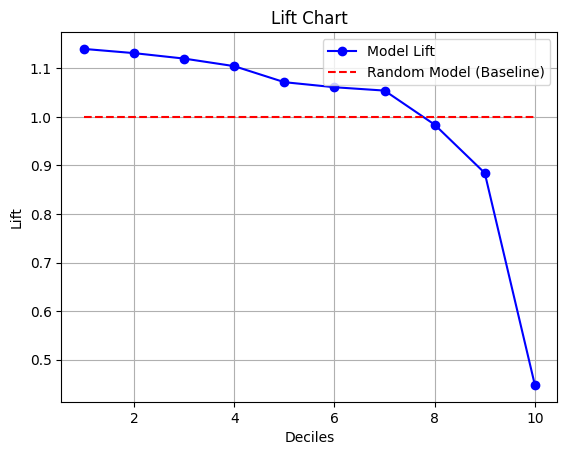

In [ ]:
import matplotlib.pyplot as plt
random_model = [1.0] * 10 
x = range(1, 11)  # Deciles
 
plt.plot(x, lift_df.toPandas()["lift"], marker="o", label="Model Lift", color="blue")
plt.plot(x, random_model, linestyle="--", label="Random Model (Baseline)", color="red")
 
plt.xlabel("Deciles")
plt.ylabel("Lift")
plt.title("Lift Chart")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute Confusion Matrix
confusion_matrix = predictions.groupBy("label", "prediction").count()
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
 
# # Compute True Positive Rate (TPR) and False Positive Rate (FPR)
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity, Recall
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Type I Error
 
print(f"True Positive Rate (TPR): {tpr}")
print(f"False Positive Rate (FPR): {fpr}")
confusion_matrix.show()

True Positive Rate (TPR): 0.9789281997918835
False Positive Rate (FPR): 0.7580946450809465
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|11289|
|  0.0|       1.0| 2435|
|  1.0|       0.0|  243|
|  0.0|       0.0|  777|
+-----+----------+-----+



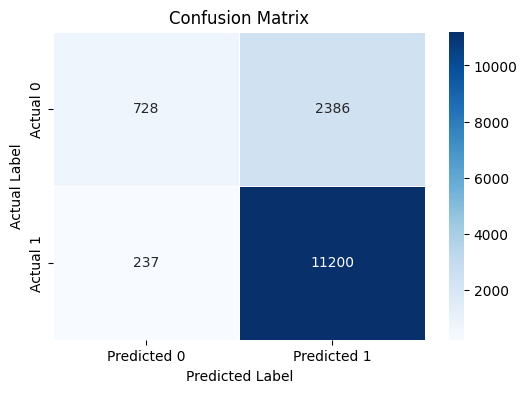

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
# Manually creating the confusion matrix
conf_matrix = pd.DataFrame(
    [[728, 2386],  # Row: True Negative (0) / False Positive (0 → 1)
     [237, 11200]], # Row: False Negative (1 → 0) / True Positive (1 → 1)
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
 
# Plot using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

Feature Importance extraction from each model

In [ ]:
import pandas as pd

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))
  



We put the features in a pandas dataframe and then plot them.

In [ ]:
features_df = pd.DataFrame(ExtractFeatureImp(rf_model.featureImportances, train_m, "features"))
features_df_binary = pd.DataFrame(ExtractFeatureImp(gbt_model.featureImportances, train_b, "features"))

C:\Users\omgit\AppData\Local\Temp\ipykernel_20920\130035276.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='name', data=features_df.head(10), palette='viridis')


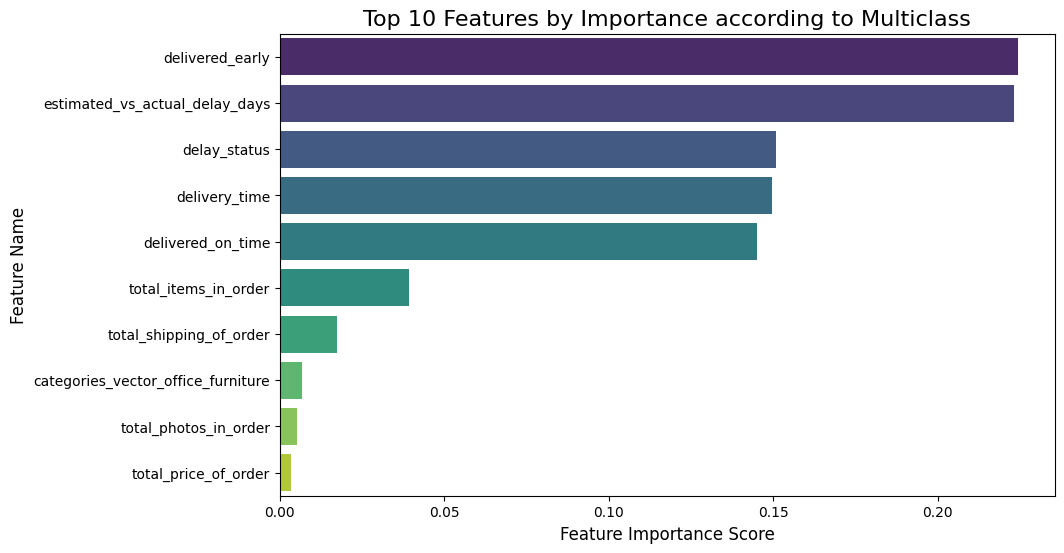

In [ ]:
# Display the top 10 features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='name', data=features_df.head(10), palette='viridis')

# Adding labels and title
plt.title('Top 10 Features by Importance according to Multiclass', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)

# Display the plot
plt.show()


C:\Users\omgit\AppData\Local\Temp\ipykernel_20920\1962473391.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='name', data=features_df_binary.head(10), palette='viridis')


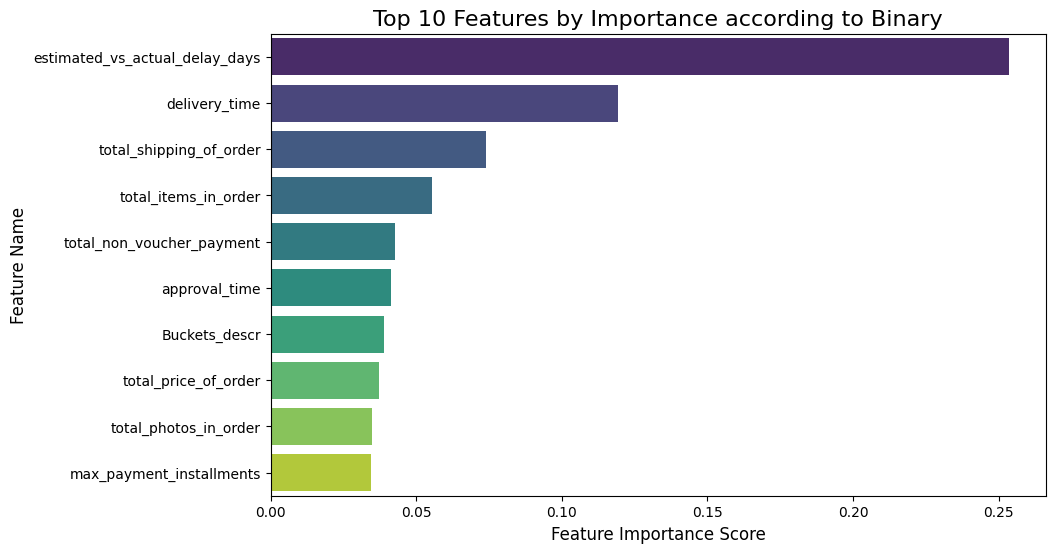

In [ ]:
# Display the top 10 features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='name', data=features_df_binary.head(10), palette='viridis')

# Adding labels and title
plt.title('Top 10 Features by Importance according to Binary', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)

# Display the plot
plt.show()

# Holdout Data

Now we do the same transformations to the holdout data.

In [ ]:
data_dir_holdout = r"C:/Users/omgit/Desktop/Big Data Proj/Holdout data-20250211"

h_order_items = load_csv(f"{data_dir_holdout}/test_order_items.csv")
h_products = load_csv(f"{data_dir_holdout}/test_products.csv")
h_order_payments = load_csv(f"{data_dir_holdout}/test_order_payments.csv")

h_orders = load_csv(f"{data_dir_holdout}/test_orders.csv")

In [ ]:
window_spec = Window.partitionBy("order_id")
h_order_items = h_order_items.withColumn("total_items_in_order", count("order_item_id").over(window_spec))

total_costs = h_order_items.groupBy("order_id").agg(
    sum(col("price")).alias("total_price_of_order"),
    sum(col("shipping_cost")).alias("total_shipping_of_order")
    )

h_order_items = h_order_items.join(total_costs, "order_id", how='left')

h_order_items = h_order_items.drop("order_item_id", "price", "shipping_cost")

h_order_items_products = h_order_items.join(h_products,"product_id","left")

In [ ]:
h_order_items_products = h_order_items_products.dropna()

In [ ]:
h_order_items_products = h_order_items_products.withColumn(
    'product_volume',
    col('product_length_cm') * col('product_height_cm') * col('product_width_cm')
)

h_order_items_grouped = h_order_items_products.groupBy("order_id").agg(
    
    avg("product_description_lenght").alias("average_product_desc_length"),
    avg("product_name_lenght").alias("average_product_name_length"),  
    round(F.first("total_items_in_order"),2).alias("total_items_in_order"),       
    round(F.first("total_price_of_order"),2).alias("total_price_of_order"),
    round(F.first("total_shipping_of_order"),2).alias("total_shipping_of_order"),
    sum('product_weight_g').alias('sum_of_all_products_weight'),
    F.first("product_category_name").alias("category"),
    sum('product_photos_qty').alias('total_photos_in_order'),
    sum('product_volume').alias('total_product_volume')        
)

In [ ]:
h_order_items_products = h_order_items_grouped

In [ ]:
bucketBorders = [3.0, 350.0, 600.0, 985.0, 4000.0]
h_order_items_products = Bucketizer(inputCol="average_product_desc_length", outputCol="Buckets_descr",splits=bucketBorders).transform(h_order_items_products)
bucketBorders_name = [3.0, 50.0, 100.0]
h_order_items_products = Bucketizer(inputCol="average_product_name_length", outputCol="Buckets_name",splits=bucketBorders_name).transform(h_order_items_products)
bucketBorders_weight = [0.0, 300.0, 800.0, 2000.0, 150000.0]
h_order_items_products = Bucketizer(inputCol="sum_of_all_products_weight", outputCol="Buckets_weight",splits=bucketBorders_weight).transform(h_order_items_products)
bucketBorders_volume = [0.0, 3000.0, 8000.0, 20000.0, 900000.0]
h_order_items_products = Bucketizer(inputCol="total_product_volume", outputCol="Buckets_volume",splits=bucketBorders_volume).transform(h_order_items_products)

In [ ]:
columns_to_drop = [
    "average_product_desc_length", 
    "average_product_name_length", 
    "sum_of_all_products_weight", 
    "total_product_volume"
]

h_order_items_products = h_order_items_products.drop("average_product_desc_length", 
    "average_product_name_length", 
    "sum_of_all_products_weight", 
    "total_product_volume")

In [ ]:
h_orders = h_orders.where(col("order_status")== "delivered").select("*")

In [ ]:
h_orders = h_orders.drop("order_status")

In [ ]:
h_orders = h_orders.dropna()

In [ ]:
h_orders = h_orders.withColumn(
    "delivery_time",
    when(
        col("order_purchase_timestamp").isNotNull() & col("order_delivered_customer_date").isNotNull(),
        round(((unix_timestamp(col("order_delivered_customer_date")) - unix_timestamp(col("order_purchase_timestamp"))) / 86400).cast("double"), 2)
    ).otherwise(-1)
)

In [ ]:
h_orders = h_orders.dropna()

In [ ]:
# Convert date columns to timestamp format
h_orders = h_orders.withColumn("order_delivered_customer_date", to_timestamp(col("order_delivered_customer_date"))) \
               .withColumn("order_estimated_delivery_date", to_timestamp(col("order_estimated_delivery_date")))

# Add calculated columns
h_orders = h_orders \
    .withColumn(
        "delivered_on_time",
        when(col("order_delivered_customer_date") <= col("order_estimated_delivery_date"), True).otherwise(False)
    ) \
    .withColumn(
        "estimated_vs_actual_delay_days",
        round((unix_timestamp(col("order_delivered_customer_date")) - unix_timestamp(col("order_estimated_delivery_date"))) / 86400, 2)
    ) \
    .withColumn(
        "delivered_early",
        when(col("order_delivered_customer_date") < col("order_estimated_delivery_date"), True).otherwise(False)
    ) \
    .withColumn(
        "approval_time",
        when(
            col("order_purchase_timestamp").isNotNull() & col("order_approved_at").isNotNull(),
            round((unix_timestamp(col("order_approved_at")) - unix_timestamp(col("order_purchase_timestamp"))) / 86400, 2)
        ).otherwise(-1)
    ) \
    .withColumn(
        "delay_status",
        when(unix_timestamp(col("order_delivered_customer_date")) > unix_timestamp(col("order_estimated_delivery_date")), True).otherwise(False)
    )

In [ ]:
h_orders= h_orders.dropna()

In [ ]:
from pyspark.sql.functions import col, when, max, sum, round

# Step 1: Create "voucher_used" column to identify if a voucher was used in a payment
h_order_payments = h_order_payments.withColumn(
    "voucher_used",
    when(col("payment_type") == "voucher", 1).otherwise(0)
)

# Step 2: Aggregate voucher-related metrics
voucher_used = h_order_payments.groupBy("order_id").agg(
    max("voucher_used").alias("if_voucher_used")
)

voucher_count_df = h_order_payments.groupBy("order_id").agg(
    sum("voucher_used").alias("voucher_count")
)

sum_voucher_payments = h_order_payments.where(col("payment_type") == "voucher").groupBy("order_id").agg(
    round(sum("payment_value"), 2).alias("total_voucher_payment")
)

# Step 3: Aggregate non-voucher-related metrics
sum_non_voucher_payments = h_order_payments.where(col("payment_type") != "voucher").groupBy("order_id").agg(
    round(sum("payment_value"), 2).alias("total_non_voucher_payment")
)

# Step 4: Calculate maximum sequential and installment payments
max_payment_sequential = h_order_payments.groupBy("order_id").agg(
    max("payment_sequential").alias("max_payment_sequential")
)

max_payment_installments = h_order_payments.groupBy("order_id").agg(
    sum("payment_installments").alias("max_payment_installments")
)

# Step 5: Identify primary payment types
primary_payment_types = h_order_payments.where(col("payment_sequential") == 1).select(
    col("order_id"), col("payment_type").alias("primary_payment_type")
)

# Step 6: Combine all metrics into a clean DataFrame
h_order_payments_clean = voucher_used.join(voucher_count_df, on="order_id", how="inner") \
    .join(max_payment_sequential, on="order_id", how="inner") \
    .join(sum_voucher_payments, on="order_id", how="left") \
    .join(sum_non_voucher_payments, on="order_id", how="left") \
    .join(primary_payment_types, on="order_id", how="left") \
    .join(max_payment_installments, on="order_id", how="inner") \
    .filter(col("primary_payment_type").isNotNull())

In [ ]:
h_order_payments_clean_nonulls = h_order_payments_clean.fillna({"total_voucher_payment": 0,"total_non_voucher_payment": 0})

In [ ]:
h_basetable = (
    h_orders
    .join(h_order_payments_clean_nonulls, on="order_id", how="inner")
    .join(h_order_items_products, on="order_id", how="inner")
    
)

In [ ]:
h_basetable.groupBy('primary_payment_type').count().show()

+--------------------+-----+
|primary_payment_type|count|
+--------------------+-----+
|              mobile| 2304|
|         credit_card| 9469|
|             voucher|  158|
|          debit_card|  487|
+--------------------+-----+



In [ ]:
h_basetable.columns

['order_id',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_id',
 'delivery_time',
 'delivered_on_time',
 'estimated_vs_actual_delay_days',
 'delivered_early',
 'approval_time',
 'delay_status',
 'if_voucher_used',
 'voucher_count',
 'max_payment_sequential',
 'total_voucher_payment',
 'total_non_voucher_payment',
 'primary_payment_type',
 'max_payment_installments',
 'total_items_in_order',
 'total_price_of_order',
 'total_shipping_of_order',
 'category',
 'total_photos_in_order',
 'Buckets_descr',
 'Buckets_name',
 'Buckets_weight',
 'Buckets_volume']

We fit the pipeline on the original table so that the structure is the same and we transform our holdout_basetable (h_basetable) on the basis of that. Our holdout data had fewer product categories compared to our training data so we had to fit it based on our training data.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Step 2: StringIndexer for 'primary_payment_type'
payment_type_indexer = StringIndexer(inputCol="primary_payment_type", outputCol="primary_payment_type_index")

# Step 3: OneHotEncoder for the indexed 'primary_payment_type'
payment_type_encoder = OneHotEncoder(inputCol="primary_payment_type_index", outputCol="primary_payment_type_vector")

# Step 4: StringIndexer for the exploded 'category' column
categories_indexer = StringIndexer(inputCol="category", outputCol="categories_index")

# Step 5: OneHotEncoder for the indexed 'category' column
categories_encoder = OneHotEncoder(inputCol="categories_index", outputCol="categories_vector")

# Step 6: Combine all transformations in a Pipeline
pipeline = Pipeline(stages=[payment_type_indexer, payment_type_encoder, categories_indexer, categories_encoder])

# Step 7: Fit the pipeline to the training data (basetable2)
pipeline_model = pipeline.fit(basetable2)

# Step 8: Transform the holdout data (h_basetable) using the fitted pipeline model
vectorized_df_holdout = pipeline_model.transform(h_basetable)

# Drop the original columns that were indexed or encoded
vectorized_df_holdout = vectorized_df_holdout.drop('primary_payment_type', 'primary_payment_type_index', 'category', 'categories_index')

# Show the result for the holdout data
vectorized_df_holdout.show()

+--------------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+-----------------+------------------------------+---------------+-------------+------------+---------------+-------------+----------------------+---------------------+-------------------------+------------------------+--------------------+--------------------+-----------------------+---------------------+-------------+------------+--------------+--------------+---------------------------+-----------------+
|            order_id|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|         customer_id|delivery_time|delivered_on_time|estimated_vs_actual_delay_days|delivered_early|approval_time|delay_status|if_voucher_used|voucher_count|max_payment_sequential|total_voucher_payment|total_non_voucher_payment|max_payment_ins

In [ ]:
dup_hold = vectorized_df_holdout

In [ ]:
vectorized_df_holdout = vectorized_df_holdout.drop(
    
    "order_purchase_timestamp", 
    "order_approved_at", 
    "order_delivered_carrier_date", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date", 
    "customer_id", 
    "review_id", 
    'categories_index',
    'categories',
    'primary_payment_type_index',
    'order_count',
    'review_score',
    'multiclass_label'
    )



Now we run it thru Rformula and transform based on the fit from the training data.

In [ ]:
from pyspark.ml.feature import RFormula

# Step 1: Fit the RFormula on the training data (basetable2)
r_form_binary = RFormula(formula="binary_label ~ . -order_id")  # Formula for binary classification
r_form_binary_model = r_form_binary.fit(basetable_binary)  # Fit on training data

r_form_multiclass = RFormula(formula="multiclass_label ~ . -order_id")  # Formula for multiclass classification
r_form_multiclass_model = r_form_multiclass.fit(basetable_multiclass)  # Fit on training data

# Step 2: Transform the holdout data (without labels)
r_form_df_binary_h_holdout = r_form_binary_model.transform(vectorized_df_holdout).select("order_id", "features")
r_form_df_multiclass_h_holdout = r_form_multiclass_model.transform(vectorized_df_holdout).select("order_id", "features")

# Show results for holdout data
r_form_df_binary_h_holdout.show()
r_form_df_multiclass_h_holdout.show()



+--------------------+--------------------+
|            order_id|            features|
+--------------------+--------------------+
|00024acbcdf0a6daa...|(92,[0,1,2,3,4,8,...|
|000576fe39319847c...|(92,[0,1,2,3,4,8,...|
|0005f50442cb953dc...|(92,[0,1,2,3,4,8,...|
|00063b381e2406b52...|(92,[0,2,4,5,8,10...|
|0006ec9db01a64e59...|(92,[0,1,2,3,4,8,...|
|0009792311464db53...|(92,[0,1,2,3,4,8,...|
|001ac194d4a326a6f...|(92,[0,1,2,3,4,8,...|
|0025c5d1a8ca53a24...|(92,[0,1,2,3,4,8,...|
|002834535f7a609a5...|(92,[0,1,2,3,4,8,...|
|0028de0ca693a1bb2...|(92,[0,1,2,3,4,8,...|
|0029c5db35ef291ce...|(92,[0,1,2,3,4,8,...|
|002f16b7bc4530031...|(92,[0,1,2,3,4,8,...|
|003423b755b562962...|(92,[0,1,2,3,4,8,...|
|00345f33869628341...|(92,[0,1,2,3,4,8,...|
|0036757472ece3dde...|(92,[0,1,2,3,4,8,...|
|0039500db36d50d7d...|(92,[0,1,2,3,4,8,...|
|003a7f59d7e08a9c6...|(92,[0,1,2,3,4,8,...|
|003a94f778ef8cfd5...|(92,[0,2,4,5,8,10...|
|003cc6161d7a2593f...|(92,[0,1,2,3,4,8,...|
|003d9fc84ad902adf...|(92,[0,1,2

Predictions on holdout data.

In [ ]:
predictions = gbt_model.transform(r_form_df_binary_h_holdout)


predictions.select('order_id',"features", "prediction", "probability").show()


predictions.select("prediction").show()



+--------------------+--------------------+----------+--------------------+
|            order_id|            features|prediction|         probability|
+--------------------+--------------------+----------+--------------------+
|00024acbcdf0a6daa...|(92,[0,1,2,3,4,8,...|       1.0|[0.14033953680331...|
|000576fe39319847c...|(92,[0,1,2,3,4,8,...|       1.0|[0.09791704110858...|
|0005f50442cb953dc...|(92,[0,1,2,3,4,8,...|       1.0|[0.08052392957753...|
|00063b381e2406b52...|(92,[0,2,4,5,8,10...|       1.0|[0.25222167685761...|
|0006ec9db01a64e59...|(92,[0,1,2,3,4,8,...|       1.0|[0.22758314047261...|
|0009792311464db53...|(92,[0,1,2,3,4,8,...|       1.0|[0.11495891568419...|
|001ac194d4a326a6f...|(92,[0,1,2,3,4,8,...|       1.0|[0.14098843510235...|
|0025c5d1a8ca53a24...|(92,[0,1,2,3,4,8,...|       1.0|[0.22324028208239...|
|002834535f7a609a5...|(92,[0,1,2,3,4,8,...|       1.0|[0.31129219873604...|
|0028de0ca693a1bb2...|(92,[0,1,2,3,4,8,...|       1.0|[0.14107916494146...|
|0029c5db35e

Exporting the results.

In [ ]:
final_holdover = predictions.select('order_id',"prediction")
df = pd.DataFrame(final_holdover.collect(), columns=final_holdover.columns)

In [ ]:
df.head()

,order_id,prediction
0,00024acbcdf0a6daa1e931b038114c75,1.0
1,000576fe39319847cbb9d288c5617fa6,1.0
2,0005f50442cb953dcd1d21e1fb923495,1.0
3,00063b381e2406b52ad429470734ebd5,1.0
4,0006ec9db01a64e59a68b2c340bf65a7,1.0


In [ ]:
df.to_csv('C:/Users/omgit/Desktop/Big Data Proj/holdout_predictions.csv', index=False)